In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
import warnings
warnings.filterwarnings("ignore")

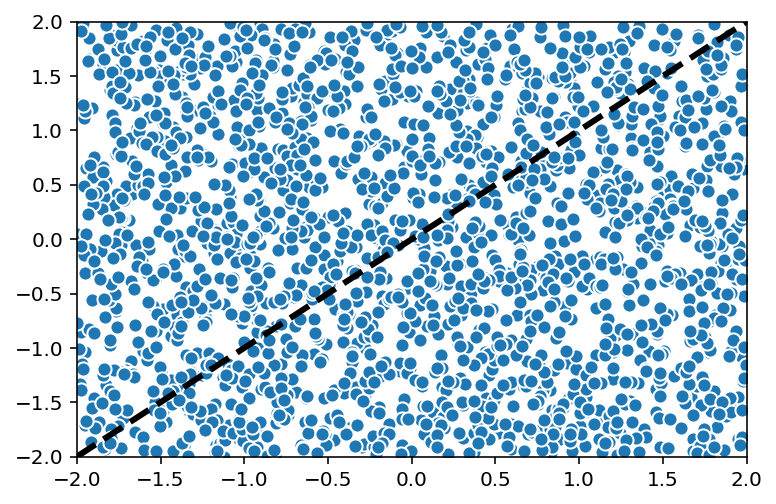

In [25]:
w=1
b=0
xd = np.array([-2,2])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=3, ls='--')
plt.scatter(bugs[:,0],bugs[:,1], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.ylabel(features[1])
# plt.xlabel(features[0])
plt.show()

In [26]:
def return_label(w,b,x,y):
    y_prime = w*x+b
    if y>y_prime:
        return 1
    else:
        return 0
# y = [0]*1000+[1]*1000
new_labels = [return_label(w,b,x,y) for x,y in zip(bugs[:,0],bugs[:,1])]


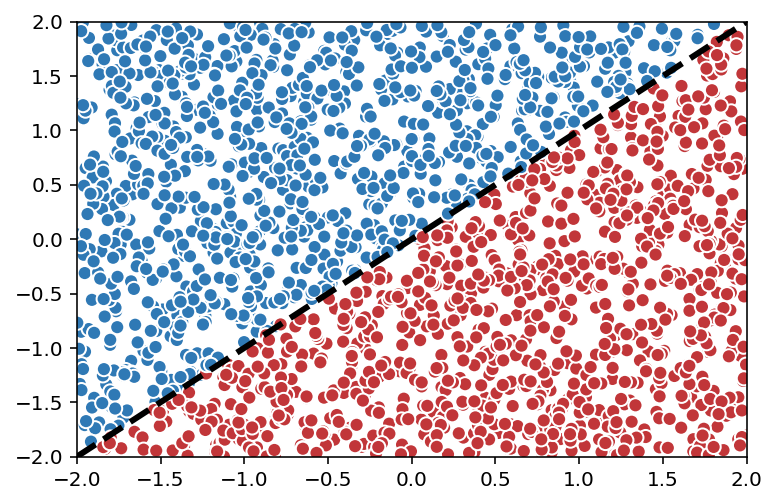

In [28]:

xd = np.array([-2,2])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=3, ls='--')
plt.scatter(bugs[:,0],bugs[:,1], c=new_labels, s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.ylabel(features[1])
# plt.xlabel(features[0])
plt.show()

In [31]:
features = ["head size","body size","tail size","texture"]
df = pd.DataFrame(bugs, columns=features)

In [33]:
df.insert(0, "label", new_labels)

In [37]:
img_id = []
for i in range(2000):
    if i < 10:
        img = f"00{i}.png"
    elif i >= 10 and i < 100:
        img = f"0{i}.png"
    else:
        img = f"{i}.png"
    img_id.append(img)

In [39]:
df.insert(0, "img_id", img_id)

In [41]:
df.to_csv("wv_3d_linear/df.csv",index=False)

In [3]:
df = pd.read_csv("datasets/wv_3d/df.csv")
features = ["head size","body size"]

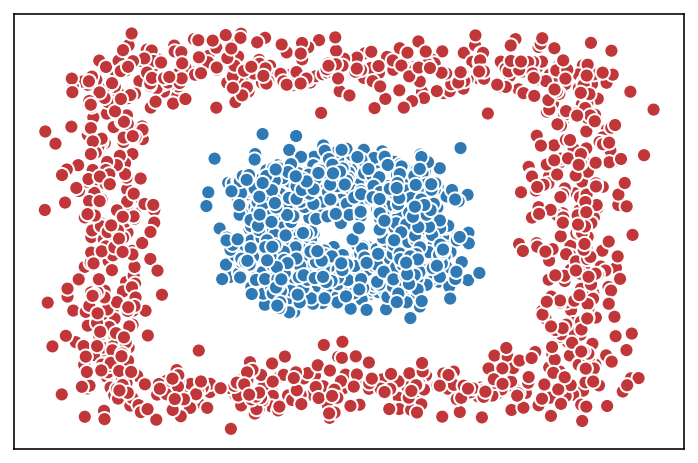

In [15]:

plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

In [55]:
dir = "wv_3d_linear/raw_imgs"
a = "wv_3d_linear/linear_2k"
for i in range(2000):
    img_id = df.iloc[i]["img_id"]
    label = df.iloc[i]["label"]
    src = os.path.join(a,img_id)
    dst = os.path.join(dir,str(label))
    # print(src, dst)
    # break
    shutil.copy(src, dst)

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(df[features],df['label'])


In [4]:
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
b = -b/w2
w = -w1/w2

In [17]:
b,w = 1.5,-2

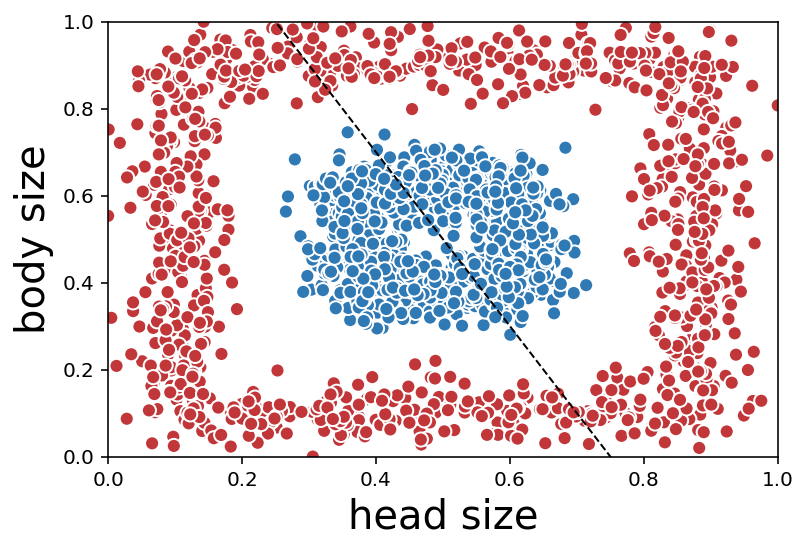

In [18]:
xd = np.array([0, 1])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.show()

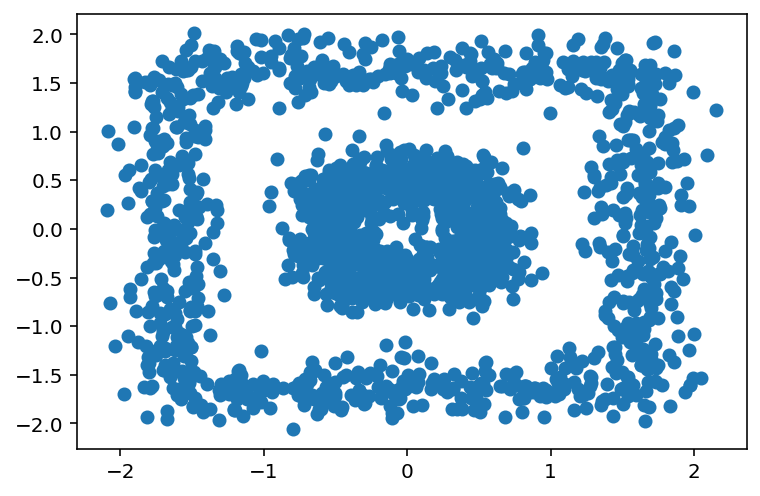

In [21]:
plt.scatter(X[:,0],X[:,1])

In [19]:
def return_label(w,b,x,y):
    y_prime = w*x+b
    if y>y_prime:
        return 1
    else:
        return 0
df['pseudo_label'] = df.apply(lambda row : return_label(w,b,row[features[0]],row[features[1]]), axis = 1)


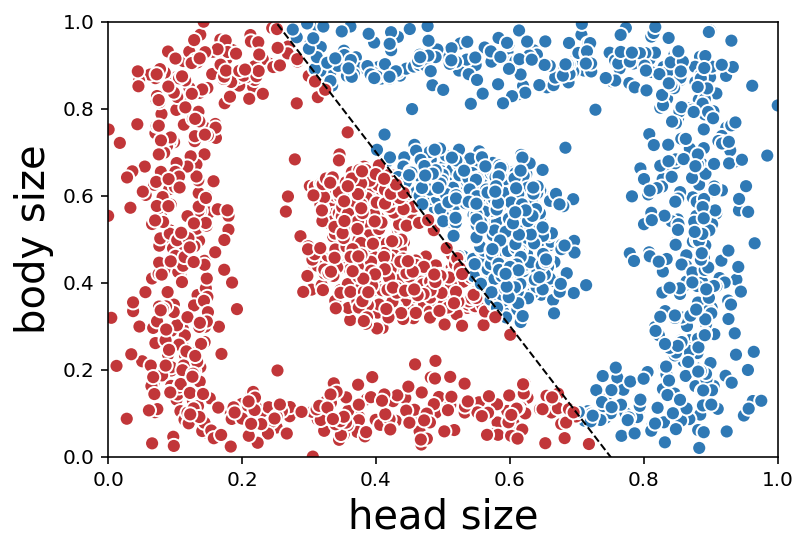

In [20]:
xd = np.array([0, 1])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(df[features[0]],df[features[1]], c=df["pseudo_label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.show()

In [21]:
total = np.arange(len(df))
valid = np.random.choice(total, 400, replace=False)
total = np.setdiff1d(total, valid)
test = np.random.choice(total, 400, replace=False)
total = np.setdiff1d(total, test)
train = total

In [22]:
train_df = df.iloc[train]
valid_df = df.iloc[valid]
test_df = df.iloc[test]

In [25]:
raw_data = "datasets/wv_3d/raw_imgs"
dir = "datasets/wv_3d/pseudo_label"
split = "valid"
for i in range(len(valid_df)):
    row = valid_df.iloc[i]
    label = row["pseudo_label"]
    src = os.path.join(raw_data,row["img_id"])
    dst = os.path.join(dir,split,str(label))
    shutil.copy(src,dst)

## synthetic features.pkl

In [2]:
X = np.load('datasets/wv_3d/features.npz')['X']
y = np.load('datasets/wv_3d/features.npz')['y']

In [17]:
files = utils.dataset_filenames("datasets/wv_3d/train")
files = [int(x.split("/")[-1][:3]) for x in files[:,0]]
train_features = X[files]
pickle.dump(train_features,open("datasets/wv_3d/train.pkl","wb"))

In [18]:
files = utils.dataset_filenames("datasets/wv_3d/valid")
files = [int(x.split("/")[-1][:3]) for x in files[:,0]]
valid_features = X[files]
pickle.dump(valid_features,open("datasets/wv_3d/valid.pkl","wb"))

In [19]:
files = utils.dataset_filenames("datasets/wv_3d/test")
files = [int(x.split("/")[-1][:3]) for x in files[:,0]]
test_features = X[files]
pickle.dump(test_features,open("datasets/wv_3d/test.pkl","wb"))

In [57]:
df = pd.read_csv("wv_3d_linear/df.csv")
features = ["head size","body size","tail size","texture"]

In [58]:
files = utils.dataset_filenames("wv_3d_linear/train")
files = [x.split("/")[-1] for x in files[:,0]]
train_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [61]:
files = utils.dataset_filenames("wv_3d_linear/valid")
files = [x.split("/")[-1] for x in files[:,0]]
valid_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [62]:
files = utils.dataset_filenames("wv_3d_linear/test")
files = [x.split("/")[-1] for x in files[:,0]]
test_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [63]:
pickle.dump(train_features, open("wv_3d_linear/train_features.pkl","wb"))
pickle.dump(valid_features, open("wv_3d_linear/valid_features.pkl","wb"))
pickle.dump(test_features, open("wv_3d_linear/test_features.pkl","wb"))

### triplet gen

In [16]:
train_features = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
valid_features = pickle.load(open("datasets/wv_3d/valid_features.pkl","rb"))
test_features = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

#### aligns & filtered

In [20]:
weights = [
    [0,0,1,1],
    [1,0,1,1],
    [0,1,1,1],
    [64,1,64,64],
    [1,1,1,1],
    [1,1,0,0]
]
aligns = [0.5,0.63,0.7,0.8,0.95,1]
total = 30000
triplet_dir = "datasets/wv_3d_linear/triplets"

In [67]:

for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    pathlib.Path(align_dir).mkdir(parents=True, exist_ok=True)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7543888888888889 0.7563333333333333 0.7525
0.7981666666666667 0.798 0.7998333333333333
0.7977222222222222 0.8036666666666666 0.8009668278046341
0.7985555555555556 0.7963333333333333 0.8088333333333333
0.8372777777777778 0.8445 0.8465
0.8811111111111111 0.8795 0.8851666666666667


### noisy

In [17]:
aligns = ["0.8","0.925"]
triplet_dir = "datasets/wv_3d_square_triplets"

In [18]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    # for p in [0.1, 0.2, 0.4, 0.8]:
    for p in [0.3, 0.5, 0.6, 0.7]:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = gen.get_noisy_triplets(train_triplets, p)
        valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
        test_noisy = gen.get_noisy_triplets(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [19]:
for align in aligns:
    # for p in [0.1, 0.2, 0.4, 0.8]:
    for p in [0.3, 0.5, 0.6, 0.7]:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

### nums

In [3]:
def dropout(triplets,p):
    keepers = np.random.choice(np.arange(len(triplets)),int(len(triplets)*p),replace=False)
    return np.array(triplets)[keepers]

In [6]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = dropout(train_triplets, p)
        valid_noisy = dropout(valid_triplets, p)
        test_noisy = dropout(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [12]:
for align in aligns:
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

## yaml generation

In [21]:
weights = [
    [0,0,1,1],
    [1,0,1,1],
    [0,1,1,1],
    [64,1,64,64],
    [1,1,1,1],
    [1,1,0,0]
]
aligns = [0.5,0.63,0.7,0.8,0.95,1]
yaml_dir = "models/configs/wv_3d/square"


In [77]:
dir = f"{yaml_dir}/unfiltered"
base = oc.load(f"{dir}/align=0.5.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base.train_triplets.replace("0.5",str(align))
    valid_triplets = base.valid_triplets.replace("0.5",str(align))
    test_triplets = base.test_triplets.replace("0.5",str(align))
    wandb_group = base.wandb_group.replace("0.5",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"{dir}/align={align}.yaml")

In [78]:
dir = f"{yaml_dir}/filtered"
base_filtered = oc.load(f"{dir}/align=0.5_filtered.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base_filtered.train_triplets.replace("0.5",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.5",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.5",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.5",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"{dir}/align={align}_filtered.yaml")

### noise

In [43]:
aligns = ["0.8","0.925"]
for align in aligns:
    dir = f"{yaml_dir}/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_noisy = oc.load(f"{dir}/p=0.1.yaml")
    # for p in [0.1, 0.2, 0.4, 0.8]:
    for p in [0.1, 0.3, 0.5, 0.6, 0.7]:
        train_triplets = base_noisy.train_triplets.replace("0.1",str(p))
        valid_triplets = base_noisy.valid_triplets.replace("0.1",str(p))
        test_triplets = base_noisy.test_triplets.replace("0.1",str(p))
        wandb_group = base_noisy.wandb_group.replace("0.1",str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_noisy,overwrite), f"{dir}/p={p}.yaml")

### num

In [10]:
aligns = ["0.8","0.925"]
for align in aligns:
    dir = f"{yaml_dir}/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_num = oc.load(f"{dir}/p=0.5.yaml")
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        train_triplets = base_num.train_triplets.replace("0.5",str(p))
        valid_triplets = base_num.valid_triplets.replace("0.5",str(p))
        test_triplets = base_num.test_triplets.replace("0.5",str(p))
        wandb_group = base_num.wandb_group.replace("0.5",str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_num,overwrite), f"{dir}/p={p}.yaml")